<a href="https://colab.research.google.com/github/elilaird/CS83212-Advanced-Neural-Networks/blob/main/Lab2_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Style Transfer

**Group Members:**
* Clay Harper
* Eli Laird


In [32]:
import tensorflow as tf
from tensorflow import keras

print(f'Tensorflow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from io import BytesIO
import requests
#from tqdm import 
import copy

from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, Model, Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D, Conv2DTranspose

Tensorflow version: 2.4.1
Keras version: 2.4.0


In [33]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title==None:
        title = str(image.shape)
    else:
        title += ' '+str(image.shape)
    plt.title(title)

In [68]:
from tensorflow.image import resize

style_img = load_img('../data/style.jpg')

style_img = resize(style_img, (256,256)) 

#style_arr = image.img_to_array(tf.squeeze(style_img))
#test_target = np.expand_dims(test_target, axis=0)'''

tensor_to_image(style_img)
style_img

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[0.19616653, 0.2370979 , 0.01382698],
         [0.3255247 , 0.33125383, 0.04577206],
         [0.23174787, 0.259532  , 0.00837929],
         ...,
         [0.8826823 , 0.2768057 , 0.02008655],
         [0.8455558 , 0.2832089 , 0.02418428],
         [0.67999774, 0.22419004, 0.06713389]],

        [[0.31433633, 0.27813652, 0.03707491],
         [0.2868413 , 0.28530943, 0.00491154],
         [0.18854359, 0.26385188, 0.02077015],
         ...,
         [0.9501513 , 0.30647022, 0.01543352],
         [0.78165984, 0.26972082, 0.10465878],
         [0.35265398, 0.07610869, 0.08463734]],

        [[0.43762833, 0.35797334, 0.04382085],
         [0.3147691 , 0.27480277, 0.00835057],
         [0.20288375, 0.28504902, 0.01923637],
         ...,
         [0.92785126, 0.33756128, 0.10213695],
         [0.80778575, 0.34528953, 0.30413797],
         [0.448022  , 0.17248392, 0.25845972]],

        ...,

        [[0.36846665, 0.4783318 , 

In [107]:
from keras.preprocessing import image

style_img = image.load_img('../data/style.jpg')
test = image.img_to_array(style_img)
test = resize(test, (256,256)) #imresize(test_img, (256, 256, 3))
tf.reshape(test, [3,256,256]).shape

TensorShape([3, 256, 256])

## VGG Manipulation

Here, we need to manipulate the given VGG code (courtesy of Justin Ledford) to make use of pooling layers or strided convolutions alternatively.  We chose to use strided convolutions because it is less computationally expensive.

In [2]:
# Load VGG
pre_trained_model = tf.keras.applications.VGG19(include_top=False,
                                                      weights='imagenet')

def vgg_layers(inputs, target_layer):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    if target_layer == 1:
        return x
    # Strides instead of maxpooling 
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', strides=2)(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    if target_layer == 2:
        return x
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', strides=2)(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    if target_layer == 3:
        return x
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4', strides=2)(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    if target_layer == 4:
        return x
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4', strides=2)(x)
    # x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    return x

def load_weights(trained_model, model):
    layer_names = [layer.name for layer in trained_model.layers]

    for layer in model.layers:
        b_name = layer.name.encode()
        if b_name in layer_names:
            layer.set_weights(trained_model.get_layer(b_name).get_weights())
            layer.trainable = False

def VGG19(trained_model, input_tensor=None, input_shape=None, target_layer=1):
    """
    VGG19, up to the target layer (1 for relu1_1, 2 for relu2_1, etc.)
    """
    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        inputs = Input(tensor=input_tensor, shape=input_shape)
    model = Model(inputs, vgg_layers(inputs, target_layer), name='vgg19')
    load_weights(trained_model, model)
    return model

Create an encoder network from the pretrained VGG network 

In [3]:
target_layer = 3
vgg_model = VGG19(pre_trained_model, input_shape=(256, 256, 3), target_layer=target_layer)
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       295168    
Total params: 555,328
Trainable params: 555,328
Non-trainable params: 0
_______________________________________________________

## Decoder Network Architecture

In [4]:
def decoder_layers(inputs, layer):
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block5_conv1')(inputs)
    if layer == 5:
        return x

    
    #x = UpSampling2D((2, 2), name='decoder_block4_upsample')(x)
    x = Conv2DTranspose(1, kernel_size=(4,4), padding='same', strides=(2,2), name='decoder_block4_2DTrans')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv4')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='decoder_block4_conv1')(x)
    if layer == 4:
        return x

    #x = UpSampling2D((2, 2), name='decoder_block3_upsample')(x)
    x = Conv2DTranspose(1, kernel_size=(4,4), padding='same', strides=(2,2), name='decoder_block3_2DTrans')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv4')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='decoder_block3_conv1')(x)
    if layer == 3:
        return x

    #x = UpSampling2D((2, 2), name='decoder_block2_upsample')(x)
    x = Conv2DTranspose(1, kernel_size=(4,4), padding='same', strides=(2,2), name='decoder_block2_2DTrans')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv2')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='decoder_block2_conv1')(x)
    if layer == 2:
        return x

    #x = UpSampling2D((2, 2), name='decoder_block1_upsample')(x)
    x = Conv2DTranspose(1, kernel_size=(4,4), padding='same', strides=(2,2), name='decoder_block1_2DTrans')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='decoder_block1_conv1')(x)
    if layer == 1:
        return x

In [298]:
#from https://stackoverflow.com/questions/47709854/how-to-get-covariance-matrix-in-tensorflow
def tf_cov(x):
    x = x - tf.expand_dims(tf.reduce_mean(x, axis=1), 1)
    fact = tf.cast(tf.shape(x)[1] - 1, tf.float32)
    b = tf.cast(tf.math.conj(tf.transpose(x)), tf.float32)
    return tf.matmul(x, b) / fact


def matrix_to_power(matrix, power):
    # Assuming real symmetric
    e_val, e_vec = tf.linalg.eigh(matrix)
    lambda_ = tf.linalg.diag(e_val**power)
    
    return e_vec@lambda_@tf.transpose(e_vec)

def new_transform(content_img, sigma_s):
    h,w,c = content_img.shape[1:]
    content_img = tf.squeeze(content_img)
    content_img = tf.reshape(content_img, [h,w,c])
    content_img = tf.reshape(content_img, [c, h * w]) 

    sigma_c = tf_cov(content_img)

    sigma_c_neg_half = matrix_to_power(sigma_c, -1/2)
    sigma_c_half = matrix_to_power(sigma_c, 1/2)
    inner = matrix_to_power(sigma_c_half@sigma_s@sigma_c_half, 1/2)
    transform_mat = sigma_c_neg_half@inner@sigma_c_neg_half

    out = transform_mat@content_img
    out = tf.reshape(out, [c,h,w])
    out = tf.expand_dims(tf.reshape(out, [h,w,c]),0)
    print('out',out.shape)
    return out

## Encoder-Decoder Architecture

In [301]:
from keras.preprocessing import image

LAMBDA=1

def l2_loss(x):
    return K.sum(K.square(x)) / 2

class EncoderDecoder:
    def __init__(self, trained_model, input_shape=(256, 256, 3), target_layer=5, style_path='../data/style.jpg', decoder_path=None):
        self.input_shape = input_shape
        self.target_layer = target_layer
        self.trained_model = trained_model

    

        self.encoder = VGG19(self.trained_model, input_shape=self.input_shape, target_layer=target_layer)
        
        self.style_image = self.load_style_img(style_path)
        self.sigma_style = self.process_style_img(self.style_image)
        
        self.transform = self.create_transform_layer()
    
        if decoder_path:
            self.decoder = load_model(decoder_path)
        else:
            self.decoder = self.create_decoder(target_layer)

        self.model = Model(self.encoder.input, self.decoder(self.transform(self.encoder.output)))
        #self.model = Model(self.encoder.input, self.decoder(self.encoder.output))
        
        self.loss = self.create_loss_fn(self.encoder)

        self.model.compile('adam', self.loss)

    def create_loss_fn(self, encoder):
        def get_encodings(inputs):
            encoder = VGG19(self.trained_model, inputs, self.input_shape, self.target_layer)
            return encoder.output

        def loss(img_in, img_out):
            encoding_in = get_encodings(img_in)
            encoding_out = get_encodings(img_out)
            return l2_loss(img_out - img_in) + \
                  LAMBDA*l2_loss(encoding_out - encoding_in)
        return loss

    def summary(self):
        self.model.summary()

    def create_decoder(self, target_layer):
        inputs = Input(shape=self.transform.output_shape[1:])
        print(inputs.shape)
        layers = decoder_layers(inputs, target_layer)
        output = Conv2D(3, (3, 3), activation='relu', padding='same',
                        name='decoder_out')(layers)
        return Model(inputs, output, name='decoder_%s' % target_layer)
    
    def create_transform_layer(self):
        inputs = Input(shape=self.encoder.output_shape[1:])
        output = new_transform(inputs, tf.constant(self.sigma_style, dtype=tf.float32))
        return Model(inputs, output)
    
    def load_style_img(self, img_path):
        img = image.load_img(img_path)
        img = image.img_to_array(img)
        img = resize(img, (self.input_shape[0], self.input_shape[1]))
        #img = tf.reshape(img, [self.input_shape[2], self.input_shape[0], self.input_shape[1]])
        return tf.expand_dims(img, axis=0)
    
    def process_style_img(self, img):
        out = self.encoder(img)  
        out = tf.squeeze(out)
        out = tf.reshape(out, [out.shape[2], out.shape[0] * out.shape[1]]) 
        return tf_cov(out)
    
    def resize_for_transform(self,img):
        img = tf.squeeze(img)

        img = tf.reshape(img, [self.input_shape[2], self.input_shape[0], self.input_shape[1]])
        return img
    

    def export_decoder(self):
        self.decoder.save('decoder_%s.h5' % self.target_layer)


## Train Two Decoders 

Decoders will be created based on the outputs of 2 different layers in the encoder model.

In [302]:
encoder_decoder = EncoderDecoder(pre_trained_model, target_layer=target_layer)
encoder_decoder.summary()

out (1, 64, 64, 256)
(None, 64, 64, 256)
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_170 (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 64, 64, 256)       295168    
_________________________________________________________________
model_18 (Functio

In [ ]:
import sys
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
#from scipy.misc import imresize, imsave DEPRACATED
#from cv2 import resize
from tensorflow.image import resize
import numpy as np


#from model import EncoderDecoder
#from util import count_num_samples

TRAIN_PATH = './data'
TARGET_SIZE = (256, 256)
BATCH_SIZE = 1
epochs = 2

datagen = ImageDataGenerator()
gen = datagen.flow_from_directory(TRAIN_PATH, target_size=TARGET_SIZE,
                                  batch_size=BATCH_SIZE, class_mode=None)


def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)
    return gen


# This needs to be in scope where model is defined
class OutputPreview(Callback):
    def __init__(self, model, test_img_path, increment, preview_dir_path):
        test_img = image.load_img(test_img_path)
        test_target = image.img_to_array(test_img)
        test_target = resize(test_target, (256,256)) #imresize(test_img, (256, 256, 3))
        #test_target = image.img_to_array(test_img)
        test_target = np.expand_dims(test_target, axis=0)
        self.test_img = test_target
        self.model = model

        self.preview_dir_path = preview_dir_path

        self.increment = increment
        self.iteration = 0

    def on_batch_end(self, batch, logs={}):
        if (self.iteration % self.increment == 0):
            output_img = self.model.predict(self.test_img)[0]
            fname = '%d.jpg' % self.iteration
            out_path = os.path.join(self.preview_dir_path, fname)
            imsave(out_path, output_img)

        self.iteration += 1


#gen = create_gen(TRAIN_PATH, TARGET_SIZE, BATCH_SIZE)

num_samples = 13395 #count_num_samples(TRAIN_PATH)
steps_per_epoch = num_samples // BATCH_SIZE

target_layer = 3 #int(sys.argv[1])

encoder_decoder = EncoderDecoder(trained_model=pre_trained_model, target_layer=target_layer)

callbacks = [OutputPreview(encoder_decoder, './data/doge.jpg', 5000, './preview-%d' % target_layer)]
encoder_decoder.model.fit_generator(gen, steps_per_epoch=steps_per_epoch,
        epochs=epochs, callbacks=callbacks)
encoder_decoder.export_decoder()

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


KeyboardInterrupt: ignored

In [ ]:
test_img = image.load_img('./data/doge.jpg')
test_img = resize(src=test_img, dsize=(256,256,3))
test_img

TypeError: ignored

# Covariance matching

## Dr. Larson 

Reusing code to test if mine works

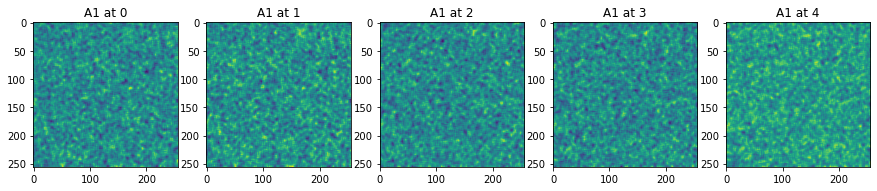

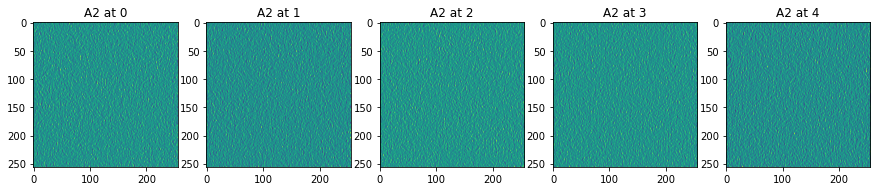

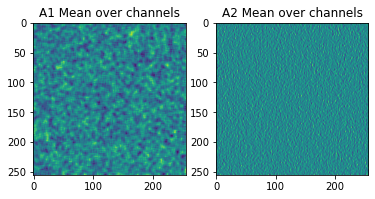

In [82]:
from scipy.ndimage import convolve
from matplotlib import pyplot as plt
%matplotlib inline
channels = 5 # number of channels to simulate
hw = 256 # height and width dimensions

# Create some Activation tensors
A1 = np.random.randn(channels,hw,hw)
A2 = np.random.rand(channels,hw,hw)

# make A1 low frequency  
filt = np.ones((3,6,6))
filt = filt / np.sum(filt)
A1 = convolve(A1,filt)
A1 = A1 - np.mean(A1)

# make A2 high frequency
filt = np.ones((2,3,3))
filt = filt / np.sum(filt)
filt[:,:,0] = filt[:,:,0]*(-1)
filt[:,:,1] = 0
A2 = convolve(A2,filt)
A2 = A2 - np.mean(A2)

# plot each tensor, average along channel
def show_active(A,title=''):
    plt.imshow(np.mean(A,0))
    plt.title(title)

n_plots = min(channels,10)
plt.figure(figsize=(15,5))   
for i in range(n_plots):
    plt.subplot(1,n_plots,i+1)
    plt.imshow(A1[i,:,:])
    plt.title(f'A1 at {i}')
    
n_plots = min(channels,10)
plt.figure(figsize=(15,5))   
for i in range(n_plots):
    plt.subplot(1,n_plots,i+1)
    plt.imshow(A2[i,:,:])
    plt.title(f'A2 at {i}')
    
plt.figure()
plt.subplot(1,2,1)
show_active(A1,'A1 Mean over channels')
plt.subplot(1,2,2)
show_active(A2,'A2 Mean over channels')

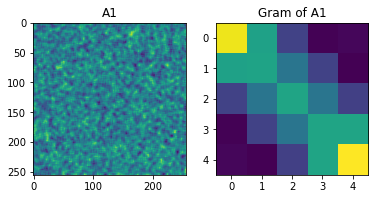

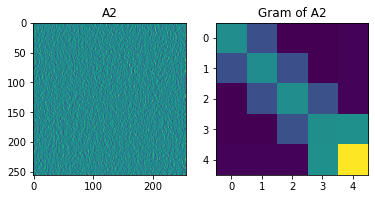

In [83]:
# calculate gram matrix (vectorized spatially) and show it
# for each activations
def gram(x):
    tmp = x.reshape((channels,hw*hw))
    return tmp @ tmp.T / (channels*hw*hw)

def show_gram(A,title=''):
    plt.figure()
    G = gram(A)
    plt.subplot(1,2,2)
    plt.imshow(G)
    plt.title('Gram of '+title)
    plt.subplot(1,2,1)
    show_active(A,title)
    return G
    

G_A1 = show_gram(A1,'A1')
G_A2 = show_gram(A2,'A2')

A1 average content difference: 0.002794411611973539
A2 average content difference: 0.0027944116119735427
A1 colored average Grammian difference: 8.982053066692947e-37
A2 colored average Grammian difference: 1.1334296245585688e-06


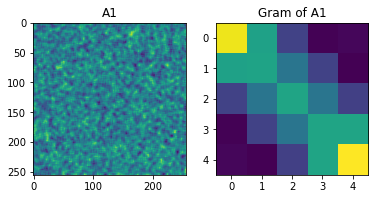

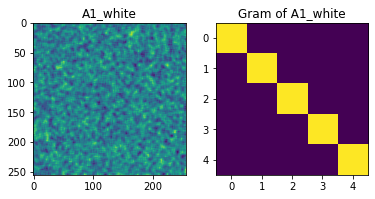

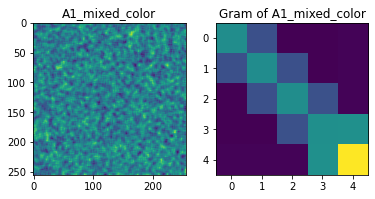

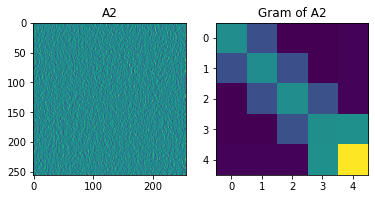

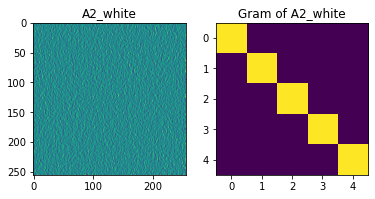

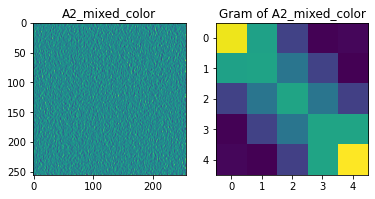

In [84]:
def whiten_cov(A):
    Avec = A.reshape((channels,hw*hw))
    AA = Avec @ Avec.T
    # notice that the SVD is of the covariance matrix
    u,s,vt = np.linalg.svd(AA,full_matrices=False)
    
    A_white = ((u @ np.diag(s**(-0.5)) @ vt) @ Avec) # no usage of the singular values here
    return A_white, (u, s, vt), Avec
    

A1_white, A1SVDcov, A1vec = whiten_cov(A1)
A2_white, A2SVDcov, A2vec = whiten_cov(A2)
    
u1, s1, _ = A1SVDcov
u2, s2, _ = A2SVDcov

# -------A1-------
# Apply inverse reconstruction to get colored version
A1_mixed_color = u2 @ np.diag(s2**(0.5)) @ u2.T @ A1_white
A1_mixed_color = A1_mixed_color.reshape((channels,hw,hw))

# -------A2-------
# Apply inverse reconstruction to get colored version
A2_mixed_color = u1 @ np.diag(s1**(0.5)) @ u1.T @ A2_white
A2_mixed_color = A2_mixed_color.reshape((channels,hw,hw))

diffA1 = np.mean((A1_mixed_color-A1)**2)
diffA2 = np.mean((A2_mixed_color-A2)**2)

# show originals
# and colored versions
G_A1 = show_gram(A1,'A1')
_ = show_gram(A1_white.reshape((channels,hw,hw)),'A1_white')
G_A1asA2 = show_gram(A1_mixed_color,'A1_mixed_color')

# show originals
# and colored versions
G_A1 = show_gram(A2,'A2')
_ = show_gram(A2_white.reshape((channels,hw,hw)),'A2_white')
G_A2asA1 = show_gram(A2_mixed_color,'A2_mixed_color')

print('A1 average content difference:', diffA1)
print('A2 average content difference:', diffA2)

print('A1 colored average Grammian difference:', np.mean((G_A2-G_A1asA2)**2))
print('A2 colored average Grammian difference:', np.mean((G_A1-G_A2asA1)**2))

## New implementation

Using the closed form solution of the transformation matrix is:

$$T = \Sigma_c^{-1/2}(\Sigma_c^{1/2}\Sigma_s\Sigma_c^{1/2})^{1/2}\Sigma_c^{-1/2}$$

Useful link: https://stats.stackexchange.com/questions/363425/raising-a-variance-covariance-matrix-to-a-negative-half-power

In [89]:
def matrix_to_power(matrix, power):
    # Assuming real symmetric
    e_val, e_vec = np.linalg.eigh(matrix)
    lambda_ = np.diag(e_val**power)

    return e_vec@lambda_@e_vec.T

In [90]:
def new_transform(content_img, style_img):
    sigma_c = np.cov(content_img)
    sigma_s = np.cov(style_img)

    simga_c_neg_half = matrix_to_power(sigma_c, -1/2)
    sigma_c_half = matrix_to_power(sigma_c, 1/2)

    inner = matrix_to_power(sigma_c_half@sigma_s@sigma_c_half, 1/2)

    transform_mat = simga_c_neg_half@inner@simga_c_neg_half
    return transform_mat@content_img

In [94]:
A1.shape

(5, 256, 256)

In [95]:
content = A1.reshape(channels, hw*hw)
style = A2.reshape(channels, hw*hw)

In [98]:
content.shape


(5, 65536)

In [92]:
colored = new_transform(content, style)
np.count_nonzero(np.isnan(colored))

0

In [249]:
colored.shape

(5, 65536)

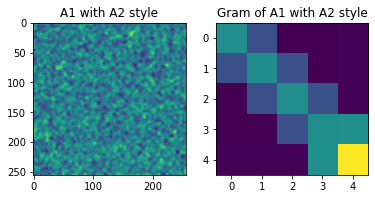

In [93]:
_ = show_gram(colored.reshape((channels,hw,hw)),'A1 with A2 style')

In [15]:
A2

array([[[ 1.04972574e-01,  1.37061351e-01,  3.34003417e-02, ...,
         -2.65237119e-02,  1.46822145e-02, -2.16445829e-02],
        [ 7.86716874e-02,  8.70346375e-02,  1.01186179e-02, ...,
          3.36621086e-03,  9.51243371e-02,  1.48221730e-02],
        [ 4.38901241e-02,  8.55355018e-02, -6.30523573e-02, ...,
          6.04028984e-02,  9.85296749e-02, -9.58648013e-03],
        ...,
        [ 7.18254860e-02,  1.45944377e-01, -2.74190817e-02, ...,
         -3.63869924e-02,  7.74573804e-02, -1.06409597e-02],
        [ 3.31081929e-02,  6.14930484e-02, -3.79323680e-02, ...,
          7.08655176e-02,  5.96188356e-02, -4.73574829e-02],
        [ 2.59198152e-02,  2.78615350e-02, -7.93483283e-02, ...,
          9.97036233e-02,  3.84339344e-02, -6.93596581e-02]],

       [[ 5.29036897e-03,  2.55913619e-02,  7.79534884e-02, ...,
         -2.58501697e-02, -1.58100453e-01, -7.86096824e-02],
        [ 2.33917826e-02,  1.38570974e-02,  2.90408792e-02, ...,
          5.14728339e-02, -6.23409982e